In [220]:
import os
from lxml import html
import requests
from BeautifulSoup import BeautifulSoup
import json
import pandas as pd
from datetime import datetime

% matplotlib inline

In [71]:
vessel_data_file = 'data/vessel_data.json'

In [255]:
# Pull existing data
page = requests.get('https://www.nwseaportalliance.com/operations/vessels')
soup = BeautifulSoup(page.text)

# Fetch the schedule data from the main page
schedule_db = {}

# Get the vessel list and href for vessel details
vessels = soup.findAll('td', {'class':'views-field views-field-title-1'})

# ETA, ETD, and and Terminal Data
eta = soup.findAll('div',{'class':'field field-name-field-vessel-eta field-type-datestamp field-label-hidden'})
etd = soup.findAll('div', {'class':'field field-name-field-vessel-etd field-type-datestamp field-label-hidden'})
terminal = soup.findAll('div', {'class':'field field-name-field-vessel-terminal field-type-text field-label-hidden'})
harbor = soup.findAll('td', {'class': 'views-field views-field-field-vessel-harbor'}) 

vessel_list = []
href_list = []
for i in xrange(len(vessels)):
    vessel = vessels[i]
    schedule_db[i] = {'vessel': vessel.findAll('a',href=True)[0].contents[0].strip(),
                     'href': vessel.findAll('a',href=True)[0]['href'],
                     'eta': eta[i].findAll('span')[0].contents[0].strip(),
                     'etd': etd[i].findAll('span')[0].contents[0].strip(),
                     'terminal': terminal[i].contents[0].split('\n')[-1].strip(),
                     'harbor': harbor[i].contents[0].strip()}

# Save the schedule db to file
with open(r'data/'+str(datetime.now())+".json", 'w') as fp:
    json.dump(vessel_dict, fp)

'2016-08-07 18:57:28.417838'

In [73]:
# Look up ship data

# Try to load an existing vessel dict
if os.path.isfile(vessel_data_file):
    try:
        with open(vessel_data_file, 'r') as fp:
            vessel_dict = json.load(fp)
    except:
        vessel_dict = {}
else:
    vessel_dict = {}

# If ship doesn't already exist in our database, collect it
for entry_id, entry in schedule_db.iteritems():
    vessel = schedule_db[entry_id]['vessel'] 

    if vessel not in vessel_dict.keys():
        print 'adding: ' + vessel
        vessel_dict[vessel] = {}
        page = requests.get('https://www.nwseaportalliance.com' + schedule_db[entry_id]['href'])
        soup = BeautifulSoup(page.text)

        # # Get the list of class names to search
        vessel_class_names = []
        for field in [i['class'] for i in soup.findAll('div')[1:]]:
            if 'field' in str(field):
                vessel_class_names.append(field)

        for class_name in vessel_class_names:
            field_name = class_name.split(' ')[1].split('-')[-1]
            field_val = soup.findAll('div', {'class':class_name})[0].contents[0].split('\n')[-1].strip()
            vessel_dict[vessel][field_name] = field_val
            
with open(vessel_data_file, 'w') as fp:
    json.dump(vessel_dict, fp)

# Analysis

In [106]:
def dict_to_df(_dict):
    df = pd.DataFrame().from_dict(_dict).T
    df.reset_index(inplace=True)
    
    return df

In [111]:
# Load vessel data as df
vessel_df = dict_to_df(vessel_dict)
vessel_df['vessel'] = vessel_df['index']
# drop the old index and empty eta, etd columns
vessel_df.drop(['index','eta','etd','harbor','terminal'], axis=1, inplace=True)
vessel_df.head()

,agent,berth,cargotype,draught,length,stevedore,width,vessel
0,HAPAG-LLOYD (AMERICA) INC,B,CONTAINERS,50.85,1145.01,WASHINGTON UNITED TERMINALS,149.61,APL GWANGYANG
1,K LINE AMERICA INC,A,AUTOS,31.07,590.52,JONES STEVEDORING COMPANY,105.64,ARCADIA HIGHWAY
2,WESTWOOD SHIPPING LINES,3,CONTAINERS / GC,38.06,685.37,PORTS AMERICA GROUP/PCT,97.93,BARDU
3,KIRBY OFFSHORE MARINE,A,LAY BERTH,0.00,347.77,,0.00,BARGE KIRBY OFFSHORE MARINE
4,OLYMPIC TUG &amp; BARGE,A,LAY BERTH,0.00,347.77,,0.00,BARGE OLYMPIC


In [112]:
# Load the schedule data as df
schedule_df = dict_to_df(schedule_db)
schedule_df.drop('index',axis=1,inplace=True)
schedule_df.head()

,eta,etd,harbor,href,terminal,vessel
0,12/05/2015 - 8:00am,09/10/2016 - 6:00pm,TAC,/node/340917,APM Terminals,MATSON PRODUCER
1,03/29/2016 - 8:00am,11/15/2016 - 8:00am,TAC,/node/340956,TOTE,SS EL YUNQUE
2,07/19/2016 - 7:00pm,07/30/2016 - 6:00pm,TAC,/node/340974,Weyco Log,BARGE SAUSE BROTHERS
3,07/25/2016 - 2:00pm,07/28/2016 - 2:00pm,TAC,/node/340975,Weyco Log,BARGE KIRBY OFFSHORE MARINE
4,07/26/2016 - 3:00pm,07/28/2016 - 3:00pm,TAC,/node/340920,Blair Terminal,BARGE OLYMPIC


In [212]:
# Join ship data to the schedule 
df = pd.merge(schedule_df, vessel_df,on='vessel')

# Convert the ETA/ETD data to datetime objects
for col in ['eta','etd']:
    df[col] = pd.to_datetime(df[col])
    
    for timefield in ['year','month','day','hour','minute']:
        df[col+'_'+timefield] = [getattr(x,timefield) for x in df[col]]

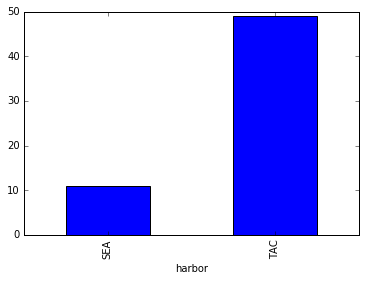

In [213]:
df.groupby('harbor').count()['vessel'].plot(kind='bar')

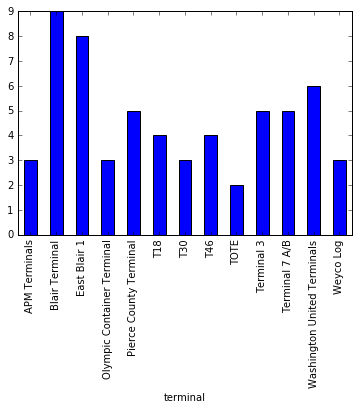

In [214]:
df.groupby('terminal').count()['vessel'].plot(kind='bar')

In [233]:
# Find pending arrivals for specific ports
my_terminal = 'Weyco Log'
my_harbor = 'SEA'
df[(df['harbor'] == my_harbor) & (df['eta'] > datetime.now())]

,eta,etd,harbor,href,terminal,vessel,agent,berth,cargotype,draught,...,eta_day,eta_hour,eta_minute,etd_year,etd_month,etd_day,etd_hour,etd_minute,time_till_eta,time_till_etd
18,2016-08-08 08:30:00,2016-08-10 00:30:00,SEA,/node/340947,T18,APL GWANGYANG,HAPAG-LLOYD (AMERICA) INC,B,CONTAINERS,50.85,...,8,8,30,2016,8,10,0,30,0 days 13:44:49.191940,2 days 05:44:49.150901
19,2016-08-08 19:30:00,2016-08-09 17:00:00,SEA,/node/340948,T18,APL GWANGYANG,HAPAG-LLOYD (AMERICA) INC,B,CONTAINERS,50.85,...,8,19,30,2016,8,9,17,0,1 days 00:44:49.191907,1 days 22:14:49.150869
21,2016-08-08 01:45:00,2016-08-09 17:45:00,SEA,/node/340953,T46,MSC ELA,NORTON LILLY,NaN,CONTAINERS,0.00,...,8,1,45,2016,8,9,17,45,0 days 06:59:49.191832,1 days 22:59:49.150798
22,2016-08-08 05:00:00,2016-08-08 17:00:00,SEA,/node/340946,T18,BSL LIMASSOL,NORTON LILLY,1,CONTAINERS,0.00,...,8,5,0,2016,8,8,17,0,0 days 10:14:49.191788,0 days 22:14:49.150765
23,2016-08-08 12:00:00,2016-08-09 18:00:00,SEA,/node/340954,T46,CSCL BOHAI SEA,COSCO,NaN,CONTAINERS,0.00,...,8,12,0,2016,8,9,18,0,0 days 17:14:49.191755,1 days 23:14:49.150732
24,2016-08-08 13:00:00,2016-08-09 18:00:00,SEA,/node/340950,T30,CSCL BOHAI SEA,COSCO,NaN,CONTAINERS,0.00,...,8,13,0,2016,8,9,18,0,0 days 18:14:49.191722,1 days 23:14:49.150699
33,2016-08-10 07:00:00,2016-08-11 23:00:00,SEA,/node/340955,T46,MOL PARTNER,NORTON LILLY,NaN,CONTAINERS,0.00,...,10,7,0,2016,8,11,23,0,2 days 12:14:49.191319,4 days 04:14:49.150391
41,2016-08-12 18:00:00,2016-08-14 20:00:00,SEA,/node/340951,T30,UASC UMM QASR,NORTON LILLY,NORTH,CONTAINERS,0.00,...,12,18,0,2016,8,14,20,0,4 days 23:14:49.191014,7 days 01:14:49.150110


In [227]:
df['time_till_eta'] = [x-datetime.now() for x in df['eta']]
df['time_till_etd'] = [x-datetime.now() for x in df['etd']]

In [238]:
# Cargo type
df.groupby('cargotype').count()['vessel']

cargotype
AUTOS                 8
AUTOS -1ST BERTH      2
CONTAINERS           28
CONTAINERS / GC       4
CONTAINERS / RORO     1
HH / RORO             1
LAY BERTH             8
LOGS                  1
RORO                  2
RORO / HH             5
Name: vessel, dtype: int64

In [252]:
print "DRAUGHT"
print "----------------"
print 'MAX:'
print df['draught'].max()
print "----------------"
print 'MEAN:'
print df['draught'].astype('float').mean()

DRAUGHT
----------------
MAX:
50.85
----------------
MEAN:
28.4341666667


In [260]:
df.groupby('terminal').count()['vessel']

terminal
APM Terminals                  3
Blair Terminal                 9
East Blair 1                   8
Olympic Container Terminal     3
Pierce County Terminal         5
T18                            4
T30                            3
T46                            4
TOTE                           2
Terminal 3                     5
Terminal 7 A/B                 5
Washington United Terminals    6
Weyco Log                      3
Name: vessel, dtype: int64

In [ ]:
# Create a lookup table for bridges associated with terminal
'Terminal 115'

Data may not be great for predicting bridge openings, but will at least predict drayage traffic.

# Prediction
Compare ship ETA/ETD data with bridge opening events